In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import torch

import matplotlib.pyplot as plt
%matplotlib inline

# https://github.com/DmitryUlyanov/Multicore-TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE

In [2]:
def softmax(x):
    # x has shape [batch_size, n_classes]
    e = np.exp(x)
    n = np.sum(e, 1, keepdims=True)
    return e/n

# Load data

In [3]:
dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
docs = dataset['data']

# store each document with an initial id
docs = [(i, doc) for i, doc in enumerate(docs)]

# "integer -> word" decoder 
decoder = np.load('decoder.npy')[()]

# for restoring document ids, "id used while training -> initial id"
doc_decoder = np.load('doc_decoder.npy')[()]

In [4]:
# original document categories
targets = dataset['target']
target_names = dataset['target_names']
targets = np.array([targets[doc_decoder[i]] for i in range(len(doc_decoder))])

# Load the trained model

In [5]:
state = torch.load('model_state.pytorch', map_location=lambda storage, loc: storage)
n_topics = 25

doc_weights = state['doc_weights.weight'].cpu().clone().numpy()
topic_vectors = state['topics.topic_vectors'].cpu().clone().numpy()
resulted_word_vectors = state['neg.embedding.weight'].cpu().clone().numpy()

# distribution over the topics for each document
topic_dist = softmax(doc_weights)

# vector representation of the documents
doc_vecs = np.matmul(topic_dist, topic_vectors)

# Show topics

In [6]:
similarity = np.matmul(topic_vectors, resulted_word_vectors.T)
most_similar = similarity.argsort(axis=1)[:, -10:]

for j in range(n_topics):
    topic_words = ' '.join([decoder[i] for i in reversed(most_similar[j])])
    print('topic', j + 1, ':', topic_words)

topic 1 : kid school food msg lsd ingredient taste chinese eat restaurant
topic 2 : atheism atheist belief theist theism exist beauchaine moral argument morality
topic 3 : batf fbi koresh compound atf fire warrant assault raid cop
topic 4 : card scsi controller bus board video motherboard port ide mhz
topic 5 : team play win player season hockey baseball playoff score espn
topic 6 : font entry cview bmp character atm color echo size truetype
topic 7 : militia atom physics theory uranium energy science infringe reactor larson
topic 8 : detector signal radar dog circuit receiver antenna voltage cts transmitter
topic 9 : comic bag silver hulk spider spiderman trek ghost comics green
topic 10 : turkey ottoman genocide muslim empire truelove turkish iran eastern arabia
topic 11 : israel israeli arab armenians arabs israelis soldier kill civilian village
topic 12 : jesus church sin bible christ christian heaven faith love word
topic 13 : dos windows microsoft apps do norton mouse driver work

# Show learned document embeddings

In [7]:
tsne = TSNE(perplexity=200, n_jobs=4)
X = tsne.fit_transform(doc_vecs.astype('float64'))

In [8]:
def plot(X):
    # X has shape [n_documents, 2]
    
    plt.figure(figsize=(16, 9), dpi=120);
    cmap = plt.cm.tab20
    number_of_targets = 20
    
    for i in range(number_of_targets):
        
        label = target_names[i]
        size = 15.0
        linewidths = 0.5
        edgecolors = 'k'
        color = cmap(i)
        
        if 'comp' in label:
            marker = 'x'
        elif 'sport' in label:
            marker = 's'
            edgecolors = 'b'
        elif 'politics' in label:
            marker = 'o'
            edgecolors = 'g'
        elif 'religion' in label:
            marker = 'P'
            size = 17.0
        elif 'sci' in label:
            marker = 'o'
            size = 14.0
            edgecolors = 'k'
            linewidths = 1.0
        elif 'atheism' in label:
            marker = 'P'
            size = 18.0
            edgecolors = 'r'
            linewidths = 0.5
        else:
            marker = 'v'
            edgecolors = 'm'
        
        plt.scatter(
            X[targets == i, 0], 
            X[targets == i, 1], 
            s=size, c=color, marker=marker,
            linewidths=linewidths, edgecolors=edgecolors,
            label=label
        );
    
    leg = plt.legend()
    leg.get_frame().set_alpha(0.3)

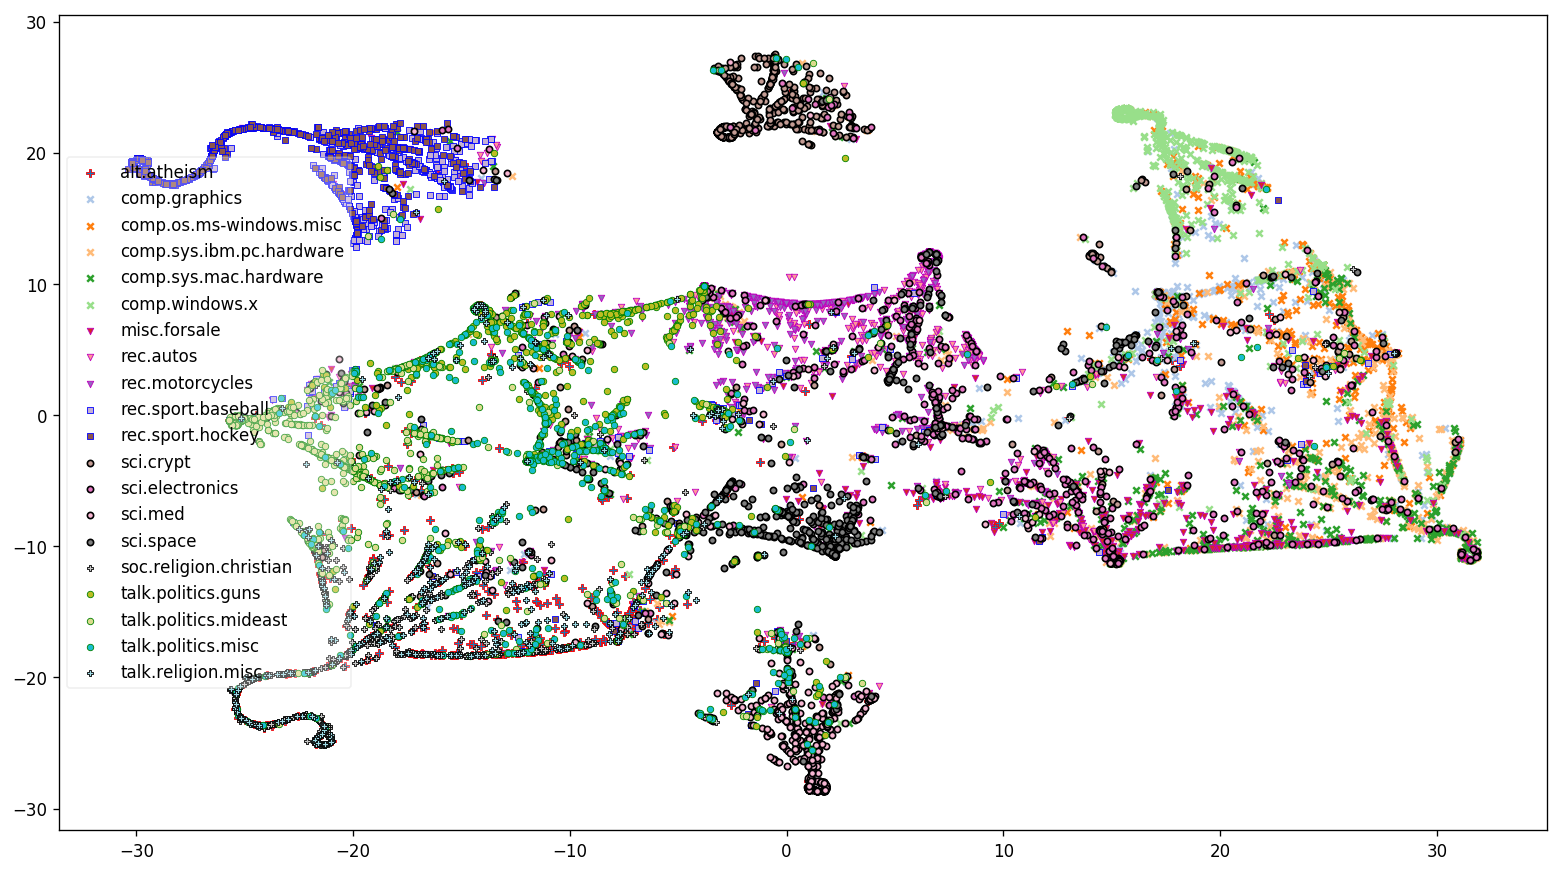

In [9]:
plot(X)  # learned document vectors

# different colors and markers represent 
# ground truth labels of each document

# open this image in new tab to see it better

# Show initial document weights (vanilla lda)

In [10]:
doc_weights_init = np.load('doc_weights_init.npy')

In [11]:
tsne = TSNE(perplexity=200, n_jobs=4)
Y = tsne.fit_transform(doc_weights_init.astype('float64'))

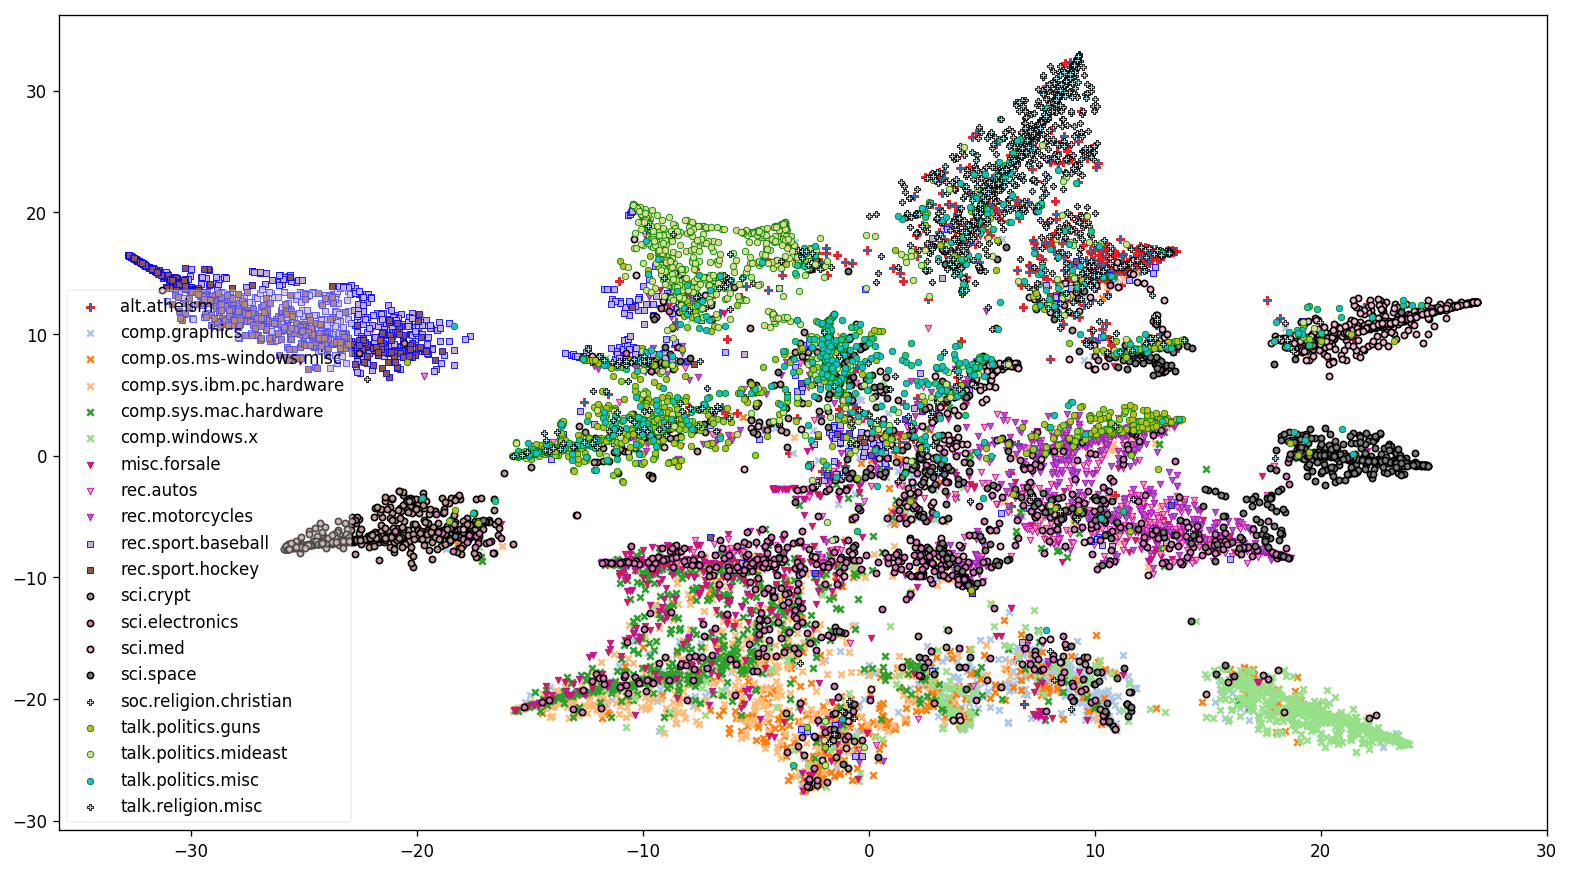

In [12]:
# to initialize topic assignments for lda2vec algorithm 
# I run normal LDA and used output distributions over topics 
# of each document

plot(Y)  # distribution over the topics for each document (output of LDA)

# different colors and markers represent 
# ground truth labels of each document

# open this image in new tab to see it better

# Explore learned topic distributions

In [13]:
tsne = TSNE(perplexity=200, n_jobs=4)
Z = tsne.fit_transform(topic_dist.astype('float64'))

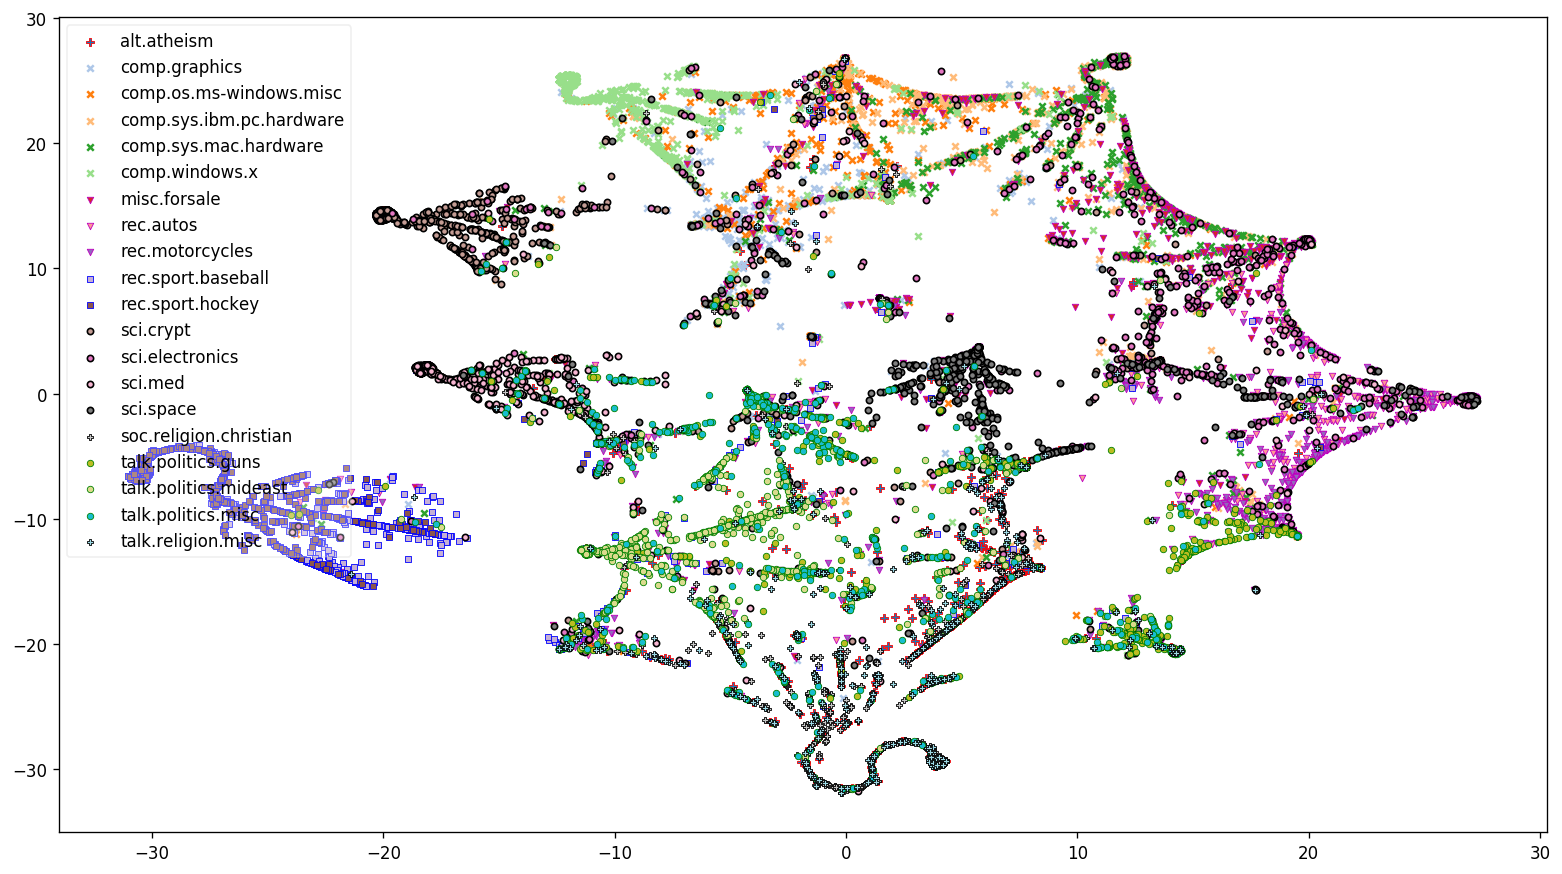

In [14]:
plot(Z)  # learned distribution over the topics for each document

# these are topic assignments as on the plot above 
# but these ones are after the training of lda2vec

# different colors and markers represent 
# ground truth labels of each document

# open this image in new tab to see it better

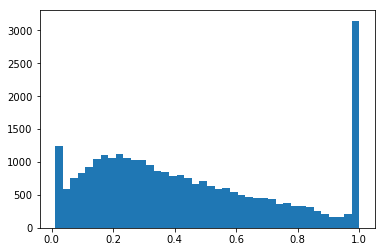

In [15]:
# distribution of nonzero probabilities
dist = topic_dist.reshape(-1)
plt.hist(dist[dist > 0.01], bins=40);

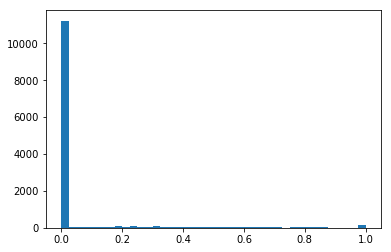

In [16]:
# distribution of probabilities for some random topic
plt.hist(topic_dist[:, 10], bins=40);

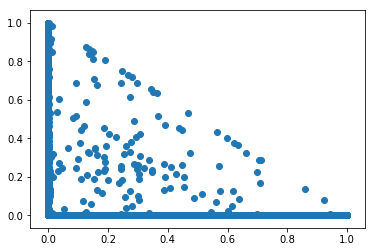

In [17]:
# topic assignments for two random topics
plt.scatter(topic_dist[:, 10], topic_dist[:, 20]);

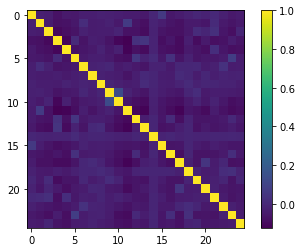

In [18]:
# correlation of topic assignments
corr = np.corrcoef(topic_dist.transpose(1, 0))
plt.imshow(corr);
plt.colorbar();

# Show a document and its topics

In [19]:
i = 100 # document id

print('DOCUMENT:')
print([doc for j, doc in docs if j == doc_decoder[i]][0], '\n')

print('DISTRIBUTION OVER TOPICS:')
s = ''
for j, p in enumerate(topic_dist[i], 1):
    s += '{0}:{1:.3f}  '.format(j, p)
    if j%6 == 0:
        s += '\n'
print(s)

print('\nTOP TOPICS:')
for j in reversed(topic_dist[i].argsort()[-3:]):
    topic_words = ' '.join([decoder[i] for i in reversed(most_similar[j])])
    print('topic', j + 1, ':', topic_words)

DOCUMENT:


IDE also uses DMA techniques.  I believe floppy controller also uses DMA,
and most A/D boards also use DMA.  DMA is no big deal, and has nothing to
do directly with SCSI.


You can thank your software for that.  If DOS had a few more brains, it
could format floppies etc. while you were doing something else.  The
hardware will support it, but DOS (at least) won't.  Again, this has   
nothing to do with SCSI.


And if you stick with DOS you'll wonder why you can't multitask. 

DISTRIBUTION OVER TOPICS:
1:0.000  2:0.000  3:0.000  4:0.795  5:0.000  6:0.000  
7:0.000  8:0.000  9:0.000  10:0.000  11:0.000  12:0.000  
13:0.203  14:0.000  15:0.000  16:0.000  17:0.000  18:0.000  
19:0.000  20:0.000  21:0.000  22:0.000  23:0.000  24:0.000  
25:0.000  

TOP TOPICS:
topic 4 : card scsi controller bus board video motherboard port ide mhz
topic 13 : dos windows microsoft apps do norton mouse driver workgroups com
topic 22 : guy batting dialing suck hit ball winfield walk morris kingman
